In [499]:
import pandas as pd 
import xpresstools as xp
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector



%matplotlib inline

### Get data and clean up formatting

In [495]:
data = pd.read_csv('isrib_raw_counts.txt',sep='\t', index_col=0)

data.shape

(10941, 16)

### Threshold

In [496]:
data_t = data.loc[data.max(axis=1) > 25]

print(str(data.shape[0]) + ' genes before thresholding')
print(str(data_t.shape[0]) + ' genes before thresholding')

10941 genes before thresholding
10941 genes before thresholding


### TPM Normalize

In [497]:
#Create length dictionary
len_dict = pd.read_csv('length_dict.txt',sep='\t', header=None, index_col=0)
del len_dict.index.name
len_dict.columns = ['length']
len_dict.length = len_dict.length / 1e3

#Perform RPK calculations
data_c = data_t.copy()
data_rpk = data_c.div(len_dict.length, axis=0)
data_rpk = data_rpk.dropna(axis=0)

#Perform per-million calculations
data_tpm = xp.rpm(data_rpk)

data_tpm.head()

,isrib_a_hek_mrna,isrib_b_hek_mrna,tm_a_hek_mrna,tm_b_hek_mrna,tmisrib_a_hek_mrna,tmisrib_b_hek_mrna,untr_a_hek_mrna,untr_b_hek_mrna,ribo_isrib_a_ribo,ribo_isrib_b_ribo,ribo_tm_a_ribo,ribo_tm_b_ribo,ribo_tmisrib_a_ribo,ribo_tmisrib_b_ribo,ribo_untr_a_ribo,ribo_untr_b_ribo
LOC388312,9.742608,18.786491,8.122820,8.833557,7.481222,11.797209,15.759706,13.798049,1.390087,0.348006,1.030507,0.704648,5.903748,3.622208,2.639873,0.000000
SAMD11,25.928557,32.097845,29.634458,24.589847,25.928541,28.482259,28.163063,30.076059,16.373065,15.728615,16.830579,13.752345,17.283179,16.032821,16.595313,17.524626
NOC2L,149.866311,155.806060,146.893739,148.565905,146.732157,137.700798,134.736761,149.486663,165.398731,169.735454,190.065040,179.980616,168.212348,157.847069,164.953761,172.255233
KLHL17,8.797207,10.184308,8.927144,6.797443,7.591076,8.087762,9.331282,7.964181,4.349506,3.798462,3.936769,4.460886,4.269083,4.600569,4.091592,3.866364
HES4,46.959197,53.755404,46.390760,45.794558,51.394651,55.270519,63.226923,69.279684,38.371897,37.253882,30.180595,27.041740,34.531083,40.349635,38.923758,40.032183


### Check replicate and RPF to RNA correlations (Fig 1E)

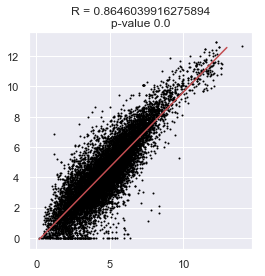

In [500]:
data_c = data_tpm.copy()

gene_a = data_c[['isrib_a_hek_mrna']].sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = data_c[['ribo_isrib_a_ribo']].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

### Perform Translation Efficiency Normalizations

In [504]:
data_te = data_tpm.copy()

data_te['isrib_a'] = data_te['ribo_isrib_a_ribo'] / data_te['isrib_a_hek_mrna']
data_te['isrib_b'] = data_te['ribo_isrib_b_ribo'] / data_te['isrib_b_hek_mrna']
data_te['tm_a'] = data_te['ribo_tm_a_ribo'] / data_te['tm_a_hek_mrna']
data_te['tm_b'] = data_te['ribo_tm_b_ribo'] / data_te['tm_b_hek_mrna']
data_te['tmisrib_a'] = data_te['ribo_tmisrib_a_ribo'] / data_te['tmisrib_a_hek_mrna']
data_te['tmisrib_b'] = data_te['ribo_tmisrib_b_ribo'] / data_te['tmisrib_b_hek_mrna']
data_te['untr_a'] = data_te['ribo_untr_a_ribo'] / data_te['untr_a_hek_mrna']
data_te['untr_b'] = data_te['ribo_untr_b_ribo'] / data_te['untr_b_hek_mrna']

data_te = data_te[['untr_a','untr_b','tm_a','tm_b','isrib_a','isrib_b','tmisrib_a','tmisrib_b']]

data_te.head()

,untr_a,untr_b,tm_a,tm_b,isrib_a,isrib_b,tmisrib_a,tmisrib_b
LOC388312,0.167508,0.000000,0.126866,0.079769,0.142681,0.018524,0.789142,0.307039
SAMD11,0.589258,0.582677,0.567939,0.559269,0.631468,0.490021,0.666570,0.562906
NOC2L,1.224267,1.152312,1.293895,1.211453,1.103642,1.089402,1.146390,1.146305
KLHL17,0.438481,0.485469,0.440989,0.656259,0.494419,0.372972,0.562382,0.568831
HES4,0.615620,0.577834,0.650573,0.590501,0.817133,0.693026,0.671881,0.730039


In [505]:
#Remove samples with 0 log-fold change and log2 transform
data_logte = data_te.copy()

data_logte = data_logte[(data_logte != 0).all(1)]

data_logte = np.log2(data_logte)

data_logte.head()

,untr_a,untr_b,tm_a,tm_b,isrib_a,isrib_b,tmisrib_a,tmisrib_b
SAMD11,-0.763028,-0.779232,-0.816191,-0.838385,-0.663217,-1.029085,-0.585172,-0.829035
NOC2L,0.291918,0.204531,0.371720,0.276738,0.142272,0.123537,0.197099,0.196991
KLHL17,-1.189413,-1.042548,-1.181187,-0.607662,-1.016194,-1.422861,-0.830378,-0.813928
HES4,-0.699888,-0.791272,-0.620216,-0.759988,-0.291358,-0.529019,-0.573723,-0.453955
AGRN,0.362573,0.918413,1.275283,0.777286,0.951994,0.485732,1.703246,1.177124


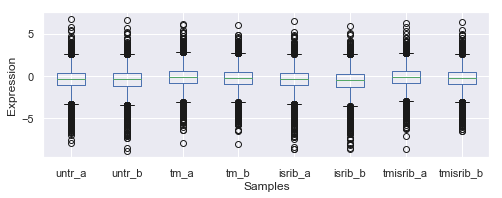

In [506]:
xp.check_samples(data_logte)

### Reproduce Figure 1 from DOI: 10.7554/eLife.05033 (original paper)

##### Tm treatment vs Untreated

In [507]:
data_fig1a = data_tpm.copy()
data_fig1a = data_fig1a[['ribo_tm_a_ribo','ribo_tm_b_ribo','tm_a_hek_mrna','tm_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1a['ribo_tm'] = data_fig1a['ribo_tm_a_ribo'] + data_fig1a['ribo_tm_b_ribo']
data_fig1a['rna_tm'] = data_fig1a['tm_a_hek_mrna'] + data_fig1a['tm_b_hek_mrna']
data_fig1a['ribo_untr'] = data_fig1a['ribo_untr_a_ribo'] + data_fig1a['ribo_untr_b_ribo']
data_fig1a['rna_untr'] = data_fig1a['untr_a_hek_mrna'] + data_fig1a['untr_b_hek_mrna']

data_fig1a['ribo_fc'] = data_fig1a['ribo_tm'] / data_fig1a['ribo_untr']
data_fig1a['rna_fc'] = data_fig1a['rna_tm'] / data_fig1a['rna_untr']

data_fig1a_plot = data_fig1a[['ribo_fc','rna_fc']]

data_fig1a_plot = data_fig1a_plot[(data_fig1a_plot != 0).all(1)]
data_fig1a_plot = data_fig1a_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1a_plot = data_fig1a_plot[~data_fig1a_plot.index.duplicated(keep='first')]

data_fig1a_plot.head()

,ribo_fc,rna_fc
LOC388312,0.657287,0.573669
SAMD11,0.896336,0.931063
NOC2L,1.097378,1.039533
KLHL17,1.055253,0.909174
HES4,0.724738,0.695704


In [508]:
data_fig1a = data_fig1a[(data_fig1a != 0).all(1)]
data_fig1a = data_fig1a.replace([np.inf, -np.inf], np.nan).dropna()

data_signif = xp.calculate_p(data_fig1a, 'ribo_tm_', 'ribo_untr_')
data_signif['p_value'] = 10 ** -data_signif['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust = stats.p_adjust(FloatVector(data_signif['p_value'].values.tolist()), method = 'BH')
data_signif['fdr'] = np.asarray(p_adjust).tolist()

In [509]:
sig_list = data_signif.loc[data_signif['p_value'] < 0.05].index.tolist()
data_fig1a_threshold = data_fig1a_plot.reindex(labels=sig_list, axis=0)
print(data_fig1a_threshold.shape)

data_fig1a_orf = data_fig1a_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1a_orf.shape)

data_fig1a_isr = data_fig1a_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1a_isr.shape)

(1386, 2)
(7, 2)
(4, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

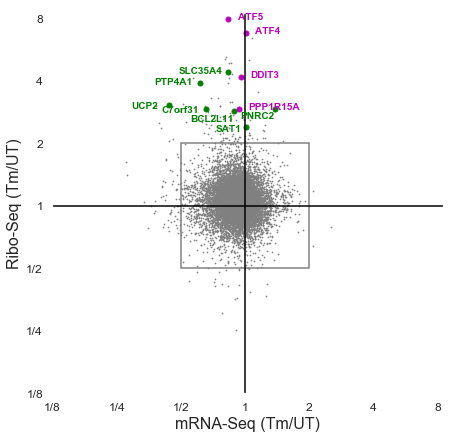

In [510]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1a_orf.iterrows():
    if index == 'BCL2L11' or index == 'PNRC2':
        ax.text(row[1], row[0] - 0.3, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
    else:
        ax.text(row[1] - 0.05, row[0] - 0.1, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
for index, row in data_fig1a_isr.iterrows():
    ax.text(row[1] + 0.1, row[0] , str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    
    
ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1a_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1a_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1a_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1a_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/tm_1a.pdf', dpi=1800, bbox_inches='tight')

plt.show

##### Tm + ISRIB treament vs untreated

In [511]:
data_fig1b = data_tpm.copy()
data_fig1b = data_fig1b[['ribo_tmisrib_a_ribo','ribo_tmisrib_b_ribo','tmisrib_a_hek_mrna','tmisrib_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1b['ribo_tmisrib'] = data_fig1b['ribo_tmisrib_a_ribo'] + data_fig1b['ribo_tmisrib_b_ribo']
data_fig1b['rna_tmisrib'] = data_fig1b['tmisrib_a_hek_mrna'] + data_fig1b['tmisrib_b_hek_mrna']
data_fig1b['ribo_untr'] = data_fig1b['ribo_untr_a_ribo'] + data_fig1b['ribo_untr_b_ribo']
data_fig1b['rna_untr'] = data_fig1b['untr_a_hek_mrna'] + data_fig1b['untr_b_hek_mrna']

data_fig1b['ribo_fc'] = data_fig1b['ribo_tmisrib'] / data_fig1b['ribo_untr']
data_fig1b['rna_fc'] = data_fig1b['rna_tmisrib'] / data_fig1b['rna_untr']

data_fig1b_plot = data_fig1b[['ribo_fc','rna_fc']]

data_fig1b_plot = data_fig1b_plot[(data_fig1b_plot != 0).all(1)]
data_fig1b_plot = data_fig1b_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1b_plot = data_fig1b_plot[~data_fig1b_plot.index.duplicated(keep='first')]

data_fig1b_plot.head()

,ribo_fc,rna_fc
LOC388312,3.608490,0.652229
SAMD11,0.976438,0.934265
NOC2L,0.966936,1.000737
KLHL17,1.114564,0.906529
HES4,0.948386,0.804980


In [512]:
data_fig1b = data_fig1b[(data_fig1b != 0).all(1)]
data_fig1b = data_fig1b.replace([np.inf, -np.inf], np.nan).dropna()

data_signif_1b = xp.calculate_p(data_fig1b, 'ribo_tmisrib_', 'ribo_untr_')
data_signif_1b['p_value'] = 10 ** -data_signif_1b['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust_1b = stats.p_adjust(FloatVector(data_signif_1b['p_value'].values.tolist()), method = 'BH')
data_signif_1b['fdr'] = np.asarray(p_adjust_1b).tolist()

In [513]:
sig_list = data_signif_1b.loc[data_signif_1b['p_value'] < 0.05].index.tolist()
data_fig1b_threshold = data_fig1b_plot.reindex(labels=sig_list, axis=0)
print(data_fig1b_threshold.shape)

data_fig1b_orf = data_fig1b_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1b_orf.shape)

data_fig1b_isr = data_fig1b_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1b_isr.shape)

(782, 2)
(7, 2)
(4, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

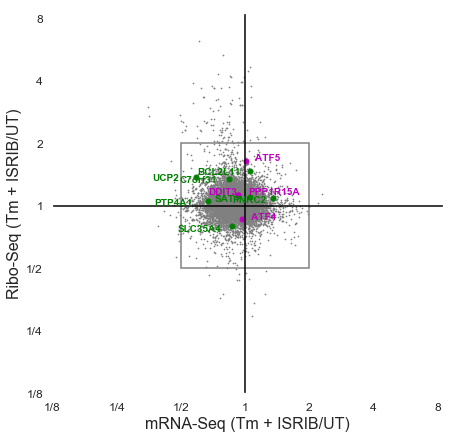

In [514]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1b_orf.iterrows():
    ax.text(row[1] - 0.1, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
for index, row in data_fig1b_isr.iterrows():
    if index == 'DDIT3':
        ax.text(row[1], row[0], str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    else:
        ax.text(row[1] + 0.1, row[0] , str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    
ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1b_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1b_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1b_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1b_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/tmisrib_1b.pdf', dpi=1800, bbox_inches='tight')

plt.show

##### ISRIB treament vs untreated

In [515]:
data_fig1c = data_tpm.copy()
data_fig1c = data_fig1c[['ribo_isrib_a_ribo','ribo_isrib_b_ribo','isrib_a_hek_mrna','isrib_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1c['ribo_isrib'] = data_fig1c['ribo_isrib_a_ribo'] + data_fig1c['ribo_isrib_b_ribo']
data_fig1c['rna_isrib'] = data_fig1c['isrib_a_hek_mrna'] + data_fig1c['isrib_b_hek_mrna']
data_fig1c['ribo_untr'] = data_fig1c['ribo_untr_a_ribo'] + data_fig1c['ribo_untr_b_ribo']
data_fig1c['rna_untr'] = data_fig1c['untr_a_hek_mrna'] + data_fig1c['untr_b_hek_mrna']

data_fig1c['ribo_fc'] = data_fig1c['ribo_isrib'] / data_fig1c['ribo_untr']
data_fig1c['rna_fc'] = data_fig1c['rna_isrib'] / data_fig1c['rna_untr']

data_fig1c_plot = data_fig1c[['ribo_fc','rna_fc']]

data_fig1c_plot = data_fig1c_plot[(data_fig1c_plot != 0).all(1)]
data_fig1c_plot = data_fig1c_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1c_plot = data_fig1c_plot[~data_fig1c_plot.index.duplicated(keep='first')]

data_fig1c_plot.head()

,ribo_fc,rna_fc
LOC388312,0.658400,0.965198
SAMD11,0.940848,0.996347
NOC2L,0.993847,1.075465
KLHL17,1.023877,1.097485
HES4,0.957823,0.760072


In [516]:
data_fig1c = data_fig1c[(data_fig1c != 0).all(1)]
data_fig1c = data_fig1c.replace([np.inf, -np.inf], np.nan).dropna()

data_signif_1c = xp.calculate_p(data_fig1c, 'ribo_isrib_', 'ribo_untr_')
data_signif_1c['p_value'] = 10 ** -data_signif_1c['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust_1c = stats.p_adjust(FloatVector(data_signif_1c['p_value'].values.tolist()), method = 'BH')
data_signif_1c['fdr'] = np.asarray(p_adjust_1c).tolist()

In [517]:
sig_list = data_signif_1c.loc[data_signif_1c['p_value'] < 0.05].index.tolist()
data_fig1c_threshold = data_fig1c_plot.reindex(labels=sig_list, axis=0)
print(data_fig1c_threshold.shape)

data_fig1c_orf = data_fig1c_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1c_orf.shape)

data_fig1c_isr = data_fig1c_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1c_isr.shape)

(468, 2)
(7, 2)
(4, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

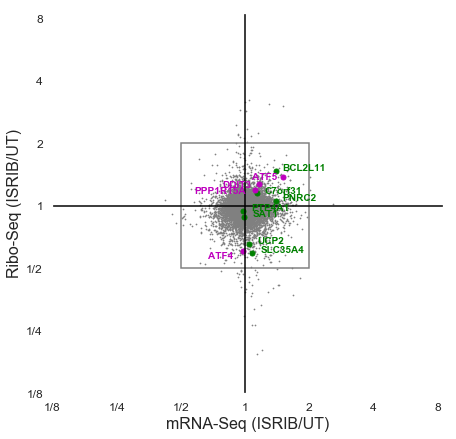

In [518]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1c_orf.iterrows():
    ax.text(row[1] + 0.1, row[0], str(index), horizontalalignment='left', size='medium', color='green', weight='semibold')
for index, row in data_fig1c_isr.iterrows():
    ax.text(row[1] - 0.1, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1c_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1c_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1c_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1c_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/isrib_1c.pdf', dpi=1800, bbox_inches='tight')

plt.show

### Metabolism analysis

In [533]:
mitocarta = pd.read_csv('./human_mitocarta_gene_list.txt',sep='\t', header=None)
mitocarta = mitocarta[0].tolist()

enzymes = pd.read_csv('./reactome_metabolism_enzymes_gene_list.txt',sep='\t', header=None)
enzymes = enzymes[0].tolist()

##### Mitocarta

In [557]:
data_fig1a_mitocarta = data_fig1a_plot.reindex(labels=mitocarta)
print(data_fig1a_mitocarta.shape)

(1158, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

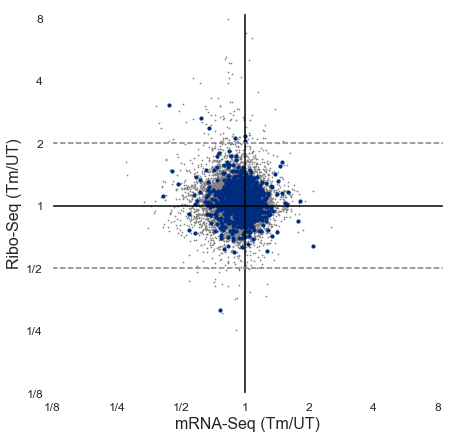

In [549]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1a_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1a_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/tm_mitocarta.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [547]:
data_fig1a_mitocarta.loc[data_fig1a_mitocarta['ribo_fc'] > 2]

,ribo_fc,rna_fc
CPS1,2.113614,0.897192
NGRN,2.057518,1.002305
SLMO1,2.375756,0.678539
CPT1B,2.168714,1.002855
UCP2,3.050365,0.440413
OBSCN,2.634064,0.622835


In [548]:
data_fig1a_mitocarta.loc[data_fig1a_mitocarta['ribo_fc'] < .5]

,ribo_fc,rna_fc
ACCS,0.315986,0.760235


In [540]:
data_fig1b_mitocarta = data_fig1b_plot.reindex(labels=mitocarta)
print(data_fig1b_mitocarta.shape)

(1158, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

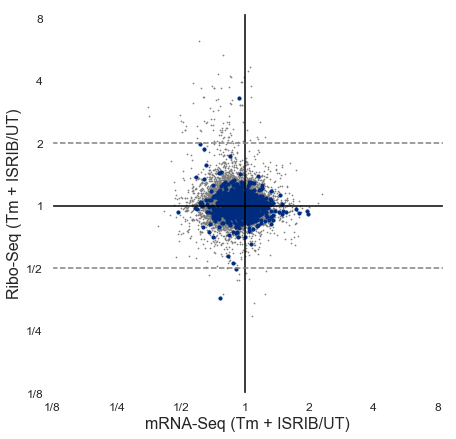

In [550]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1b_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1b_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/tmisrib_mitocarta.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [551]:
data_fig1b_mitocarta.loc[data_fig1b_mitocarta['ribo_fc'] > 2]

,ribo_fc,rna_fc
CPT1B,3.297108,0.942314


In [552]:
data_fig1b_mitocarta.loc[data_fig1b_mitocarta['ribo_fc'] < .5]

,ribo_fc,rna_fc
MTHFD2L,0.496379,0.910554
ACCS,0.360912,0.765878


In [545]:
data_fig1c_mitocarta = data_fig1c_plot.reindex(labels=mitocarta)
print(data_fig1c_mitocarta.shape)

(1158, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

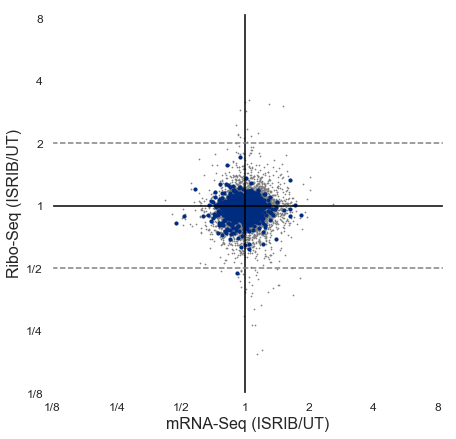

In [553]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1c_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1c_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/isrib_mitocarta.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [554]:
data_fig1c_mitocarta.loc[data_fig1c_mitocarta['ribo_fc'] > 2]

,ribo_fc,rna_fc


In [555]:
data_fig1c_mitocarta.loc[data_fig1c_mitocarta['ribo_fc'] < 0.5]

,ribo_fc,rna_fc
ACCS,0.474,0.918171


##### Metabolic Enzymes

In [558]:
data_fig1a_enzymes = data_fig1a_plot.reindex(labels=enzymes)
print(data_fig1a_enzymes.shape)

(2118, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

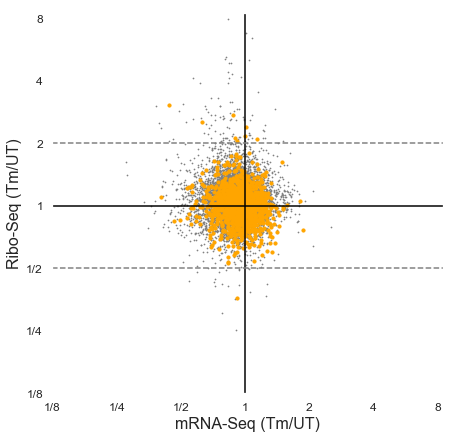

In [560]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1a_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1a_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

plt.savefig('./plots/tm_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [561]:
data_fig1a_enzymes.loc[data_fig1a_enzymes['ribo_fc'] > 2]

,ribo_fc,rna_fc
CHST2,21.297727,0.753911
CPS1,2.113614,0.897192
CPT1B,2.168714,1.002855
UCP2,3.050365,0.440413
ST3GAL3,2.043694,0.915975
OAZ1,2.092680,1.134720
SAT1,2.382764,1.012906
ABCA1,2.530167,0.630767
PLCD1,2.724307,0.877997


In [562]:
data_fig1a_enzymes.loc[data_fig1a_enzymes['ribo_fc'] < 0.5]

,ribo_fc,rna_fc
PPARA,0.357937,0.922434


In [563]:
data_fig1b_enzymes = data_fig1b_plot.reindex(labels=enzymes)
print(data_fig1b_enzymes.shape)

(2118, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

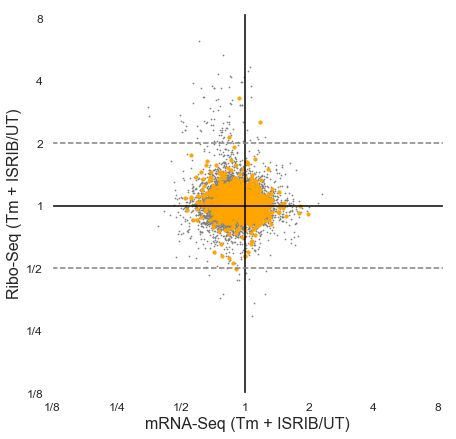

In [571]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1b_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1b_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

plt.savefig('./plots/tmisrib_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [572]:
data_fig1b_enzymes.loc[data_fig1b_enzymes['ribo_fc'] > 2]

,ribo_fc,rna_fc
CHST2,11.810668,0.862957
CPT1B,3.297108,0.942314
ADRA2C,2.531533,1.182848
PLCD1,2.155057,0.843942


In [573]:
data_fig1b_enzymes.loc[data_fig1b_enzymes['ribo_fc'] < 0.5]

,ribo_fc,rna_fc
MTHFD2L,0.496379,0.910554


In [574]:
data_fig1c_enzymes = data_fig1c_plot.reindex(labels=enzymes)
print(data_fig1c_enzymes.shape)

(2118, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

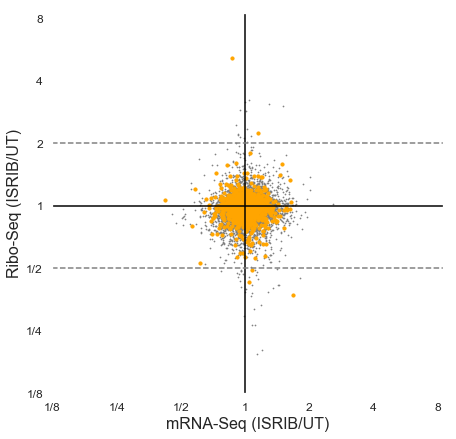

In [575]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1c_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1c_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

plt.savefig('./plots/isrib_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [576]:
data_fig1c_enzymes.loc[data_fig1c_enzymes['ribo_fc'] > 2]

,ribo_fc,rna_fc
CHST2,5.127726,0.874063
ADRA2C,2.247355,1.146820


In [577]:
data_fig1c_enzymes.loc[data_fig1c_enzymes['ribo_fc'] < 0.5]

,ribo_fc,rna_fc
NMRAL1,0.491047,1.073825
PIP5K1B,0.372499,1.676863
CSAD,0.429304,1.044388
